# Technical Overlays

In [479]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import urllib2
import requests
from bs4 import BeautifulSoup

This code loops through each symbol taken from the company list and gathers the information from yahoo finance.
A dataframe is created of each stock using fix_yahoo_finance and then stored as csv files to be easily used later.

In [480]:
#from pandas_datareader import data as pdr
#import fix_yahoo_finance as yf
#yf.pdr_override()
#data = pdr.get_data_yahoo('SPY', start='2017-01-01', ends='2017-12-31')
#print data
# Link for the list of companies
# http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download
#stockList = pd.read_csv('../companylist.csv')
#print stockList['Symbol']
#for i in range(len(stockList['Symbol'])):
#    data = pdr.get_data_yahoo(stockList['Symbol'][i], start='2017-01-01', ends='2017-12-31')
#    fileName = stockList['Symbol'][i] + ".csv"
#    data.to_csv(fileName)

The package glob is used to loop through every csv file in the stocks folder and then stores them in a double array with the stock's name and the dataframe associated with it.

In [542]:
stocks = []
stocks.append([])
stocks.append([])
import glob
path = "./stocks/*.csv"
for fname in glob.glob(path):
    stocks[1].append(pd.read_csv(fname))
    stocks[1][-1].Date = pd.to_datetime(stocks[1][-1].Date)
    stocks[0].append(fname)

The stocks are looped through, and the stocks that are less than 322 are deleted from the list to ensure that all the stocks are the same length.

In [591]:
lengths = []
newLengths = []
newStocks = []
newStocks.append([])
newStocks.append([])
for i in range(len(stocks[1])):
    lengths.append(len(stocks[1][i]['Close']))
    newStocks[0].append(stocks[0][i])
    newStocks[1].append(stocks[1][i])
    newLengths.append(lengths[i])
    if(lengths[i]<322):
        del newLengths[-1]
        del newStocks[0][-1]
        del newStocks[1][-1]
print newStocks[1][5].head()

        Date        Open        High         Low       Close   Adj Close  \
0 2017-01-03  115.800003  116.330002  114.760002  116.150002  113.847588   
1 2017-01-04  115.849998  116.510002  115.750000  116.019997  113.720169   
2 2017-01-05  115.919998  116.860001  115.809998  116.610001  114.298470   
3 2017-01-06  116.779999  118.160004  116.470001  117.910004  115.572701   
4 2017-01-09  117.949997  119.430000  117.940002  118.989998  116.631287   

     Volume  
0  28781900  
1  21118100  
2  22193600  
3  31751900  
4  33561900  


Method to get the rolling mean, upper band, and lower band to be used as the Bollinger Bands.

In [ ]:
def get_bollinger_bands(df, window, num_std):
    rolling_mean = df["Close"].rolling(window=window).mean()
    rolling_std = df["Close"].rolling(window=window).std()
    
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return rolling_mean, upper_band, lower_band

Function to plot the Bollinger Bands.

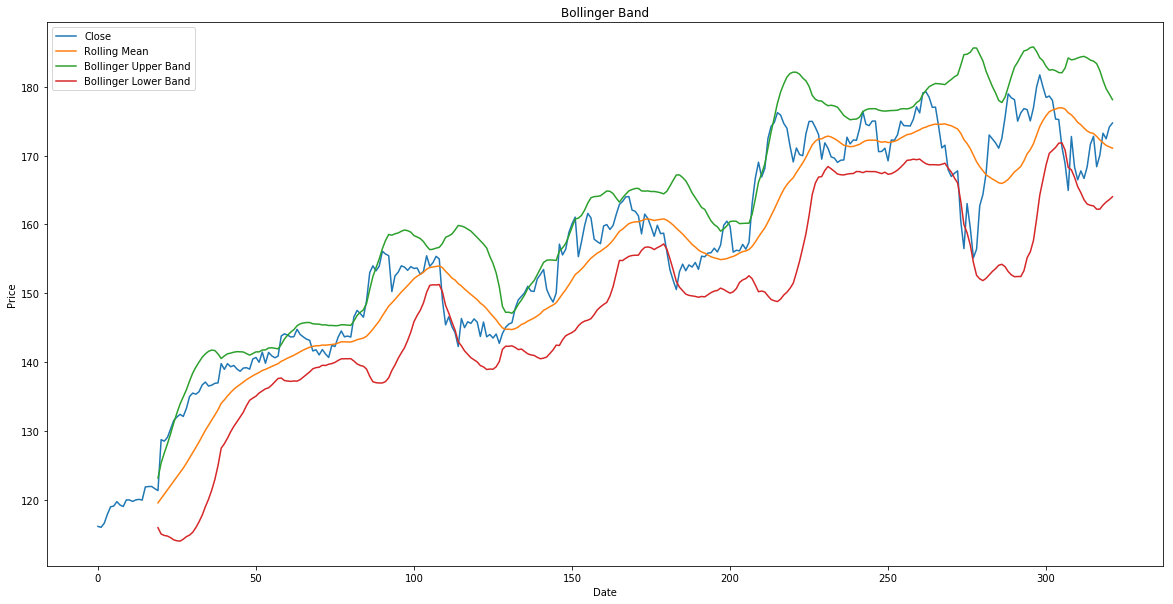

In [577]:
def plot_bollinger_bands(RM, UB, LB, Stock):
    ax = Stock.plot(title="Bollinger Band", label = Stock.name, figsize=(20, 10))
    RM.plot(label='Rolling Mean', ax=ax)
    UB.plot(label='Bollinger Upper Band', ax=ax)
    LB.plot(label='Bollinger Lower Band', ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()

window = 20
num_std = 2
RM, UBB, LBB, = get_bollinger_bands(newStocks[1][5], window, num_std)

plot_bollinger_bands(RM, UBB, LBB, newStocks[1][5]['Close'])

Function to get the Average True Range to be used with the Keltner Channel.

In [546]:
def get_ATR(df, ATRDays):
    df2 = df
    i = 1
    
    TR_1 = [df2.at[0, 'High'] - df2.at[0, 'Low']]
    
    while i< (len(df2.index)):
        hl = abs(df2.at[i-1, 'High'] - df2.at[i-1, 'Low'])
        hCp = abs(df2.at[i-1, 'High'] - df2.at[i, 'Close'])
        lCp = abs(df2.at[i-1, 'Low'] - df2.at[i, 'Close'])
        TR = max(hl, hCp, lCp)
        TR_1.append(TR)
        i = i+1

    TR_s = pd.Series(TR_1)
    i = ATRDays
    ATRarray = [TR_s[:i].mean()]

    while i< (len(TR_s)):
        ATRarray.append((ATRarray[i-ATRDays-1]*(ATRDays-1) + TR_1[i])/ATRDays)
        i=i+1
    ATR = pd.Series(ATRarray, name = "ATR")
    return ATR

Function to get the Exponential Moving Average, the Upper Keltner Channel, and the Lower Keltner Channel.

In [547]:
def get_keltner_channel(df, ATRDays, EMADays, multiplier):
    ATR = get_ATR(df, ATRDays)
    ATR_s = pd.Series(np.zeros(ATRDays-1))
    ATR = pd.concat([ATR_s, ATR], ignore_index=True)
    
    SMA = (df['High'] + df['Low'] + df['Close'])/3
        
    EMA = pd.Series(SMA.ewm(span = EMADays, min_periods = EMADays).mean(), name='EMA')
    KCU = pd.Series(SMA.ewm(span = EMADays, min_periods = EMADays).mean(), name='KCU')
    KCL = pd.Series(SMA.ewm(span = EMADays, min_periods = EMADays).mean(), name='KCL')
    
    KCU = KCU + (multiplier * ATR)
    KCL = KCL - (multiplier * ATR)
    
    return EMA, KCU, KCL
    

The function plots the keltner channel.

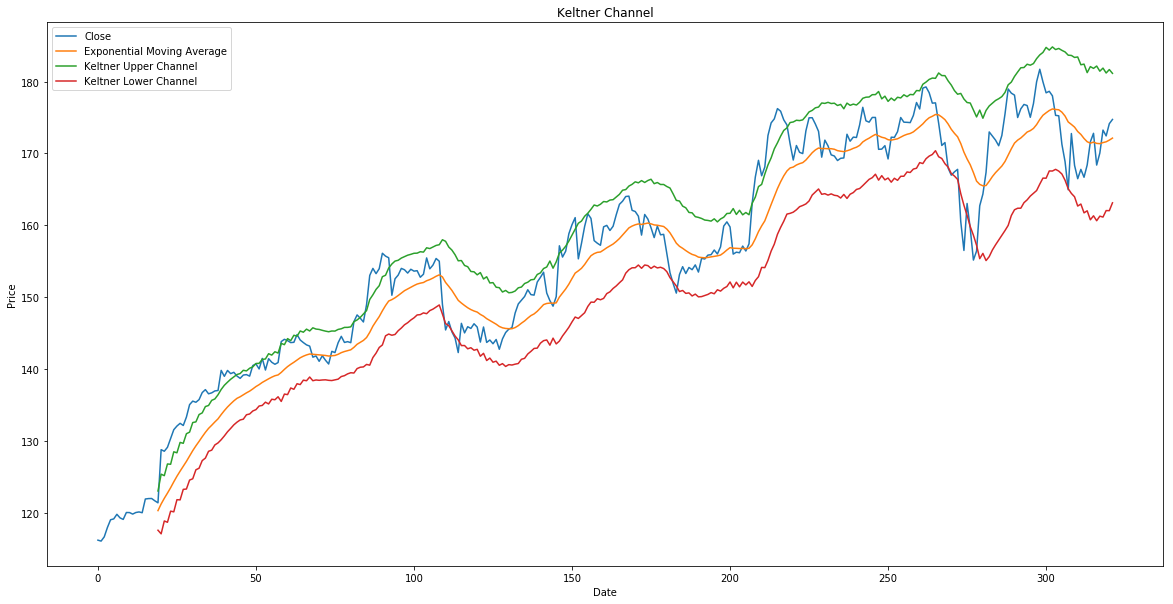

In [548]:
def plot_keltner_channel(EMA, KCU, KCL, Stock):
    ax = Stock.plot(title="Keltner Channel", label = Stock.name, figsize=(20, 10))
    EMA.plot(label='Exponential Moving Average', ax=ax)
    KCU.plot(label='Keltner Upper Channel', ax=ax)
    KCL.plot(label='Keltner Lower Channel', ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()

ATRDays = 10
EMADays = 20
multiplier = 2

EMA, KCU, KCL = get_keltner_channel(newStocks[1][5], ATRDays, EMADays, multiplier)
plot_keltner_channel(EMA, KCU, KCL, newStocks[1][5]['Close'])

The function gets the Simple Moving Average, the Upper Simple Moving Average, and the Lower Simple Moving Average for the Moving Average Envelope.

In [549]:
def get_moving_average_envelope(df, days, percent):
    SMA = pd.Series(df['Close'].rolling(window=days).mean())
    USMA = SMA + (SMA * percent)
    LSMA = SMA - (SMA * percent)
    
    return SMA, USMA, LSMA


The function plots the Moving Average Envelope.

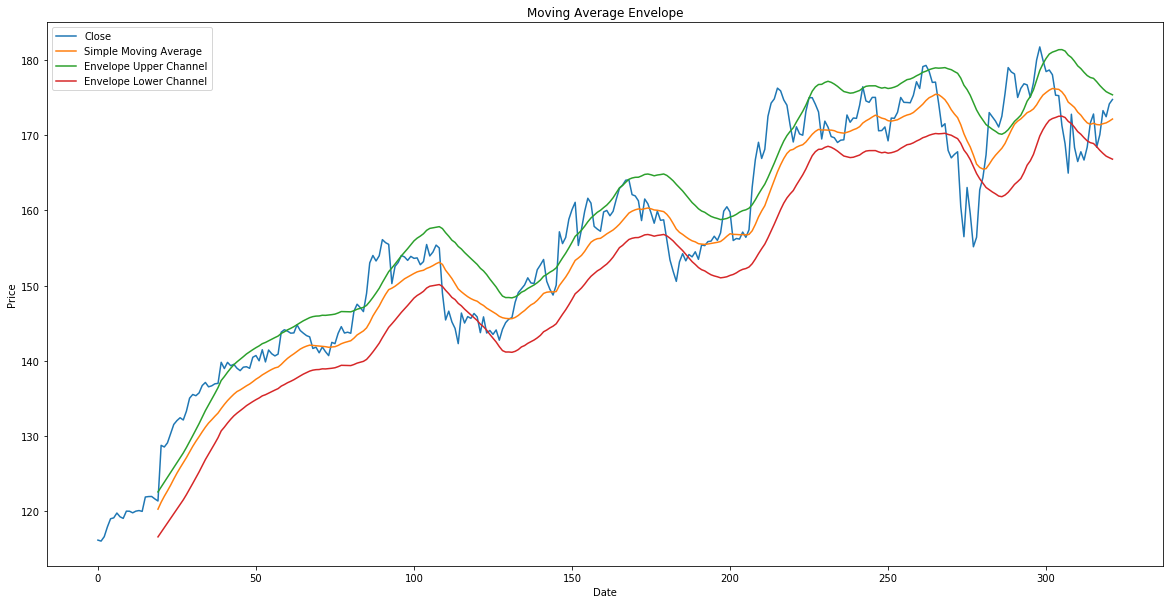

In [556]:
def plot_MAE(SMA, USMA, LSMA, Stock):
    ax = Stock.plot(title="Moving Average Envelope", label = Stock.name, figsize=(20, 10))
    EMA.plot(label='Simple Moving Average', ax=ax)
    USMA.plot(label='Envelope Upper Channel', ax=ax)
    LSMA.plot(label='Envelope Lower Channel', ax=ax)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    plt.show()
    
window = 20

SMA, USMA, LSMA = get_moving_average_envelope(newStocks[1][5], window, .025)

plot_MAE(SMA, USMA, LSMA, newStocks[1][5]['Close'])

The function gets the money made by the parabolic sar, the rising sar, and the falling sar. The plot is also created at the end of the cell by the close price, and the rising and falling sar.

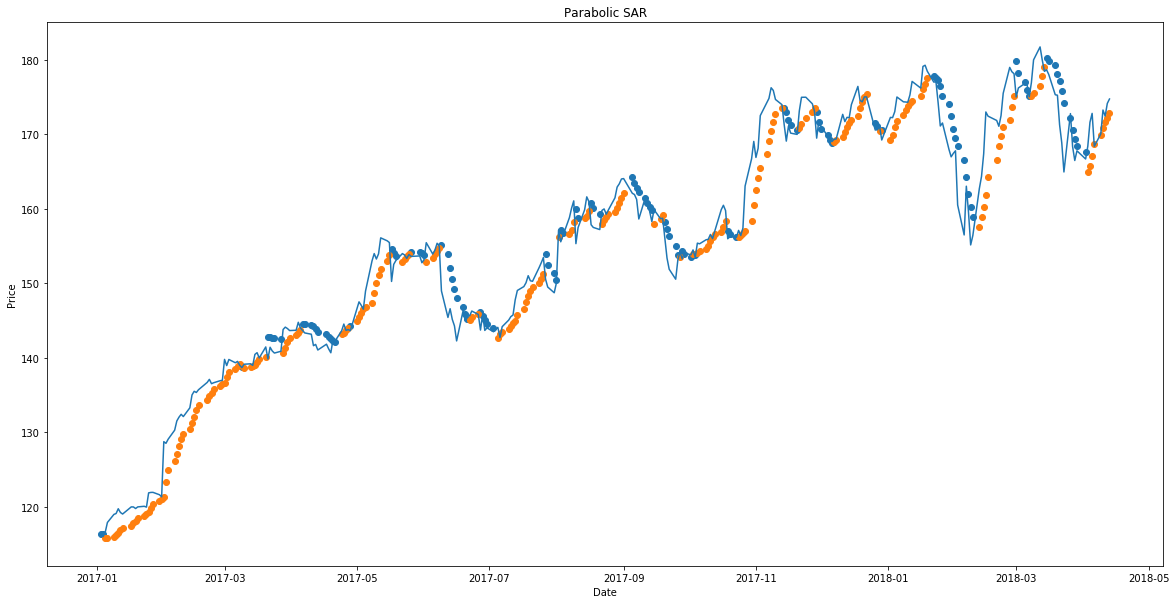

In [575]:
# define the first rising sar and falling sar
#check for the trend, deside rising or falling
def get_Parabolic_SAR(df):
    #exam_data01 = {'Date': apple_stock['Date'],'High': apple_stock['High'], 'Low': apple_stock['Low'], 
    #              'Close': apple_stock['Close']}
    #df = pd.DataFrame(exam_data01)
    rising_sar = []
    falling_sar = []
    # index 0 is the date, index 1 is the value
    rising_sar.append([])
    rising_sar.append([])
    falling_sar.append([])
    falling_sar.append([])
    # 1 mean start with rising sar, 0 means start with falling sar
    sar = []
    #deside whether start with falling sar or start with rising sar
    if(df['Close'][1] > df['Close'][0]):
        sar.append(1)
    else:
        sar.append(0)
    
    r_extreme_point = []
    f_extreme_point = []
    r_af = 0.02
    f_af = 0.02

    PSARMoney = 10000
    SellAmount = 1000
    BuyAmount = 1000
    numStocks = PSARMoney/df['Close'][0]
    PSARMoney = 0
    #final_sar = []
    #go through data row by row
    for index, row in df.iterrows():
        #if this is the first stock price, follow the sar we descide before
        #if not, compre the price and descide it is a falling or a rising
        if(index == 0):
            if(sar[0] == 1):
                rising_sar[0].append(row['Date'])
                rising_sar[1].append(row['Low'])
                r_extreme_point.append(row['High'])
            else:
                falling_sar[0].append(row['Date'])
                falling_sar[1].append(row['High'])
                f_extreme_point.append(row['Low'])
        else:
            #if the close price is higher than falling sar, change to rising sar
            #if the close price is lower than rising sar, change to falling sar
            #calculate both extreme point every day
        
            #prior_r_sar = rising_sar[1][len(rising_sar[1])-1]
            #prior_f_sar = falling_sar[1][len(falling_sar[1])-1]
            #prior_r_ep = r_extreme_point[len(r_extreme_point)-1]
            #prior_f_ep = f_extreme_point[len(f_extreme_point)-1]
        
            if(sar[index-1] == 1):
            
                if(row['Close'] < rising_sar[1][len(rising_sar[1])-1]):
                    #now changing to downward trend, falling sar
                
                    if((numStocks-SellAmount/row['Close'])>0):
                        numStocks = numStocks - SellAmount/row['Close']
                        PSARMoney = PSARMoney + SellAmount
                    elif(numStocks>0):
                        PSARMoney = PSARMoney + numStocks*row['Close']
                        numStocks = 0
                
                    r_sar = 0.02
                    try:
                        f_extreme_point.append(row['Low'])
                        sar.append(0)
                        falling_sar[0].append(row['Date'])
                        #falling_sar[1].append((falling_sar[1][len(falling_sar[1])-1] - f_af * 
                        #                      (falling_sar[1][len(falling_sar[1])-1] - f_extreme_point[len(f_extreme_point)-1])))
                        falling_sar[1].append(row['High'])
                        if(row['Low'] < f_extreme_point[len(f_extreme_point)-1]):
                            f_extreme_point.append(row['Low'])
                            if(f_af < 0.2):
                                f_af += 0.02
                    except:
                        #falling_sar[0].append(row['Date'])
                        falling_sar[1].append(row['High'])
                        f_extreme_point.append(row['Low'])
                else:
                    # continue upward trend, rising sar
                    sar.append(1)
                    rising_sar[0].append(row['Date'])
                    rising_sar[1].append((rising_sar[1][len(rising_sar[1])-1] + r_af * 
                                          (r_extreme_point[len(r_extreme_point)-1] - rising_sar[1][len(rising_sar[1])-1])))
                
                    if(row['High'] > r_extreme_point[len(r_extreme_point)-1]):
                        r_extreme_point.append(row['High'])
                        if(r_af < 0.2):
                            r_af += 0.02
            else:
                if(row['Close'] > falling_sar[1][len(falling_sar[1])-1]):
                    #change to upward trend
                
                    numStocks = numStocks + BuyAmount/row['Close']
                    PSARMoney = PSARMoney - BuyAmount
                
                    f_sar = 0.02
                    try:
                        r_extreme_point.append(row['High'])
                        sar.append(1)
                        rising_sar[0].append(row['Date'])
                        #rising_sar[1].append((rising_sar[1][len(rising_sar[1])-1] + r_af * 
                         #                     (r_extreme_point[len(r_extreme_point)-1] - rising_sar[1][len(rising_sar[1])-1])))
                        rising_sar[1].append(row['Low'])
                        if(row['High'] >= r_extreme_point[len(r_extreme_point)-1]):
                            r_extreme_point.append(row['High'])
                            if(r_af < 0.2):
                                r_af += 0.02
                    except:
                        #rising_sar[0].append(row['Date'])
                        rising_sar[1].append(row['Low'])
                        r_extreme_point.append(row['High'])
                else:
                    #continue with downward trend
                    sar.append(0)
                    falling_sar[0].append(row['Date'])
                    falling_sar[1].append((falling_sar[1][len(falling_sar[1])-1] - f_af * 
                                           (falling_sar[1][len(falling_sar[1])-1] - f_extreme_point[len(f_extreme_point)-1])))
                    if(row['Low'] <= f_extreme_point[len(f_extreme_point)-1]):
                        f_extreme_point.append(row['Low'])
                        if(f_af < 0.2):
                            f_af += 0.02
    PSARMoney = PSARMoney + numStocks*df['Close'].iloc[-1]
    return PSARMoney, rising_sar, falling_sar

PSARMoney, rising_sar, falling_sar = get_Parabolic_SAR(newStocks[1][5])
fig, ax = plt.subplots(1,1, figsize=(20,10))
x = newStocks[1][5].Date
y = newStocks[1][5]['Close']
ax.set_xlabel('Date')
#ax.tick_params(labelsize=30)
ax.set_ylabel('Price')
ax.set_title('Parabolic SAR')
plt.plot(x, y, alpha=1)
plt.scatter(falling_sar[0], falling_sar[1], alpha=1)
plt.scatter(rising_sar[0], rising_sar[1], alpha=1)
plt.show()

The cell includes the functions need to create the price channel. The cell includes a function to create the upper channel, the lower channel, the middle channel, the current price, and the date. At the end the methods are used to create the plot for the Price Channel.

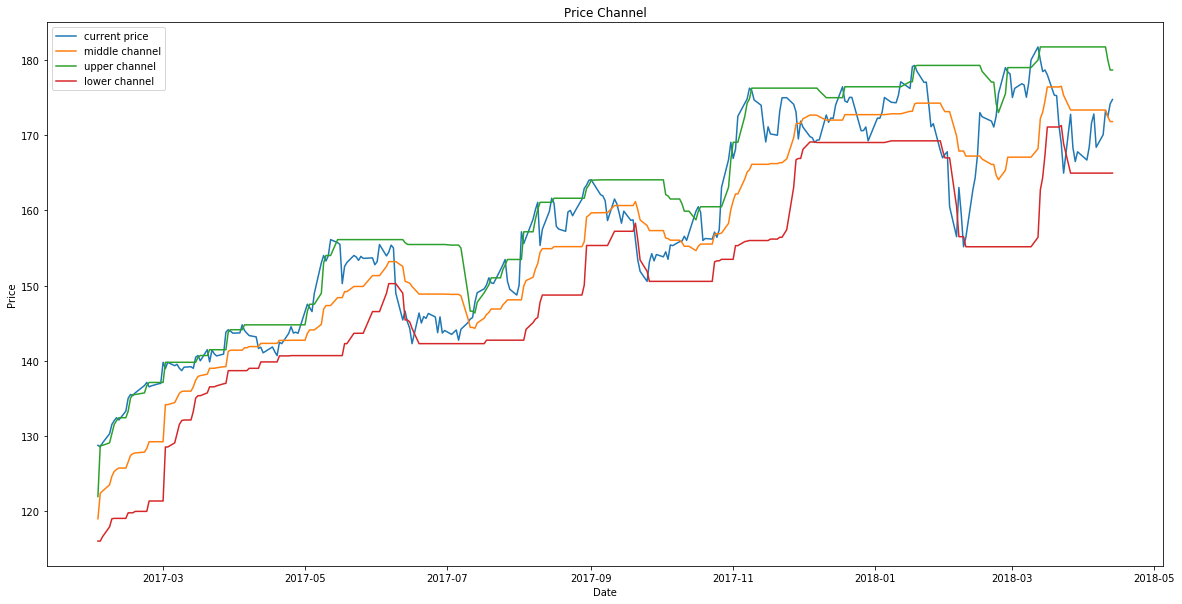

In [576]:
#df = pd.read_csv('../../dataset/AAPL-weekly.csv')
# Draw the close only plot 
def createUpperChannel(close_price, index):
    # choose the highest close price within index-days
    # ex: index = 2, from date No.3
    upper_channel = []
    # include index, exclude len(df['Close'])
    for a in range(index, len(close_price)):
        current_max = close_price[a-index]
        # 1, 2, 3, 4, 5
        for b in range((a - index), a):
            if (close_price[b] > current_max):
                current_max = close_price[b]
        upper_channel.append(current_max)
    return upper_channel

def createLowerChannel(close_price, index):
    lower_channel = []
    # include index, exclude len(df['Close'])
    for a in range(index, len(close_price)):
        current_min = close_price[a-index]
        # 1, 2, 3, 4, 5
        for b in range((a - index), a):
            if (close_price[b] < current_min):
                current_min = close_price[b]
        lower_channel.append(current_min)
    return lower_channel

def createMiddleChannel(upper, lower):
    middle_channel = []
    # include index, exclude len(df['Close'])
    for a in range(0, len(upper)):
        middle_channel.append((upper[a]+lower[a])/2)
    return middle_channel

def createCurrentPrice(close_price, index):
    current_price = []
    for a in range(index, len(close_price)):
        current_price.append(close_price[a])
    return current_price

def createDate(close_price, index):
    date = []
    for a in range(index, len(close_price)):
        date.append(close_price[a])
    return date

upper = createUpperChannel(newStocks[1][5].Close, 20)
lower = createLowerChannel(newStocks[1][5].Close, 20)
middle = createMiddleChannel(upper, lower)
current = createCurrentPrice(newStocks[1][5].Close, 20)
date = createDate(df.Date, 20)

info = {'Date':date, 'Upper':upper, 'Middle':middle,
        'Lower':lower, 'Current':current}
channel_data = pd.DataFrame(info)
channel_data.Date = pd.to_datetime(channel_data.Date)

fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(channel_data['Date'], channel_data['Current'], label="current price")
ax.plot(channel_data['Date'], channel_data['Middle'], label="middle channel")
ax.plot(channel_data['Date'], channel_data['Upper'], label="upper channel")
ax.plot(channel_data['Date'], channel_data['Lower'], label="lower channel")
ax.set_title('Price Channel')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

The function returns the money made by using the price channel. This is done by buying stocks when the closing price goes below the lower channel and selling stocks when the closing price goes above the upper channel.

In [534]:
#version 1
def get_Money_Price_Channel(channel_data):
    cash = 10000
    step_amount = 1000
    volume = 0
    current_price = channel_data.Current[0]

    #buy $10000 stock at the begining
    volume += int(10000 / current_price)
    cash = 10000 - volume * current_price

    for a in range(0,len(upper)):
        current_price = channel_data.Current[a]
        if current_price > channel_data.Upper[a]:
            #buy stocks use $1000, the step amount
            num_to_sell = int(step_amount / current_price)
            if(volume < num_to_sell):
                cash += volume * current_price
                volume = 0
            else:
                volume = volume - num_to_sell
                cash += num_to_sell * current_price
        # if the price lower than the lower channel, I need to sell stock
        elif current_price < channel_data.Lower[a]:
            volume = volume + int(step_amount/current_price)
            cash = cash - step_amount
        
    # The final amount of money I can get is to sell all my stock at the last day + my cash remained
    balance = volume * channel_data.Current[len(channel_data.Current)-1] + cash
    return balance

This function is used to compute how much money is made by the technical overlays bollinger band, keltner channel, and moving average envelope. The upper and lower bands and the stock close price is entered into the function and when the close price goes below the lower band stocks are bought and when the close price goes above the upper band stocks are sold.

In [535]:
def computeMoney(money, StockSold, StockBuy, Stock, UB, LB):
    days = Stock.count()-UB.count()
    numStocks = money/Stock[0]
    money = 0
    for i in range(UB.count()):
        
        if(Stock[i+days]<=UB[i+days] and i != 0 and Stock[i+days-1]>=UB[i+days-1]):
            if(numStocks-StockSold/Stock[i+days]>0):
                numStocks = numStocks - (int)(StockSold/Stock[i+days])
                money = money + StockSold
                
            elif(numStocks>0):
                money = money + numStocks*Stock.iloc[i+days]
                numStocks = 0
            
        if(Stock[i+days]>=LB[i+days] and i != 0 and Stock[i+days-1]<=LB[i+days-1]):
            stocksBought = (int)(StockBuy/Stock[i+days])
            numStocks = numStocks + stocksBought
            money = money - (stocksBought*Stock[i+days])
            
    money = money + numStocks*Stock.iloc[-1]
            
    return money

This cell loops through every stock and finds how much money is made using each technical overlay. The max is found for each stock and stored as the best technical overlay for that stock.

In [536]:
endMoneyBB = []
endMoneyBB.append([])
endMoneyBB.append([])

endMoneyKC = []
endMoneyKC.append([])
endMoneyKC.append([])

endMoneyME = []
endMoneyME.append([])
endMoneyME.append([])

endMoneyPSAR = []
endMoneyPSAR.append([])
endMoneyPSAR.append([])

endMoneyPC = []
endMoneyPC.append([])
endMoneyPC.append([])

endMoneyDif = []
for i in range(len(newStocks[1])):

    beginMoney = 10000
    amountSold = 1000
    amountBought = 1000
    RM, UBB, LBB, = get_bollinger_bands(newStocks[1][i], window, num_std)

    EMA, KCU, KCL = get_keltner_channel(newStocks[1][i], ATRDays, EMADays, multiplier)
    
    SMA, USMA, LSMA = get_moving_average_envelope(newStocks[1][i], window, .025)
    
    
    
    upper = createUpperChannel(newStocks[1][i].Close, 20)
    lower = createLowerChannel(newStocks[1][i].Close, 20)
    middle = createMiddleChannel(upper, lower)
    current = createCurrentPrice(newStocks[1][i].Close, 20)
    date = createDate(newStocks[1][i].Date, 20)

    info = {'Date':date, 'Upper':upper, 'Middle':middle,
            'Lower':lower, 'Current':current}
    channel_data = pd.DataFrame(info)
    channel_data.Date = pd.to_datetime(channel_data.Date)
    
    
    endMoneyBB[0].append(newStocks[0][i])
    endMoneyBB[1].append(computeMoney(beginMoney, amountSold, amountBought, newStocks[1][i]['Close'], UBB, LBB))
    
    endMoneyKC[0].append(newStocks[0][i])
    endMoneyKC[1].append(computeMoney(beginMoney, amountSold, amountBought, newStocks[1][i]['Close'], KCU, KCL))
    
    endMoneyME[0].append(newStocks[0][i])
    endMoneyME[1].append(computeMoney(beginMoney, amountSold, amountBought, newStocks[1][i]['Close'], USMA, LSMA))
    
    endMoneyPC[0].append(newStocks[0][i])
    endMoneyPC[1].append(get_Money_Price_Channel(channel_data))
    
    endMoneyPSAR[0].append(newStocks[0][i])
    PSARMoney, rising_sar, falling_sar = get_Parabolic_SAR(newStocks[1][i])
    endMoneyPSAR[1].append(PSARMoney)
    
    endMoneyDif.append(np.max([endMoneyBB[1][i], endMoneyKC[1][i], endMoneyME[1][i], endMoneyPSAR[1][i], endMoneyPC[1][i]]))

#print endMoneyDif

[17439.42690093027, 12330.150222000004, 8425.7999999999956, 15321.024519164503, 11890.549614, 15906.207825451958, 13126.79062138488, 14149.101338900464, 17229.032746196095, 10547.099999999999, 15122.120299000004, 13806.345597853637, 27650.851886409739, 5792.0240612516536, 45374.759944000005, 227950.34199999998, 2522.6710332103321, 25539.40430064352, 14164.100027999999, 20193.300000000003, 9080.6029256934307, 10680.550002, 42468.033948999997, 6226.7100713991731, 15002.693770250367, 9923.8126630704719, 11287.444768441859, 12830.529288999998, 14373.859999999997, 2922.0591130850021, 6818.3329504022513, 13828.999649999998, 18152.722717840988, 10649.800138000001, 17862.679571999997, 8321.7312840000013, 14442.170000000002, 9441.7750000000015, 10363.879999999999, 6243.3196296296301, 12253.953296223826, 12406.934028405574, 11093.409749999997, 44936.195, 21273.461751388324, 16263.679999999998, 13872.845936159953, 24452.929999999986, 15286.619999999999, 23995.721215000001, 12361.457958777781, 123

The cell creates a dataframe that stores which overlay is the best for each stock along with how much money is made.

In [580]:
bestOver = pd.DataFrame()
bestOver['Stock'] = newStocks[0]
bestOver['Best Overlay Price'] = endMoneyDif

bestOverlay = []
for i in range(len(endMoneyDif)):
    if(endMoneyDif[i] == endMoneyBB[1][i]):
        bestOverlay.append("Bollinger Band")
    elif(endMoneyDif[i] == endMoneyKC[1][i]):
        bestOverlay.append("Keltner Channel")
    elif(endMoneyDif[i] == endMoneyME[1][i]):
        bestOverlay.append("Moving Envelope")
    elif(endMoneyDif[i] == endMoneyPC[1][i]):
        bestOverlay.append("Price Channel")
    elif(endMoneyDif[i] == endMoneyPSAR[1][i]):
        bestOverlay.append("Parabolic SAR")
    else:
        bestOverlay.append("Error")
bestOver["Best Overlay"] = bestOverlay
print bestOver.head()

               Stock  Best Overlay Price    Best Overlay
0  ./stocks/AABA.csv        17439.426901   Parabolic SAR
1   ./stocks/AAL.csv        12330.150222   Price Channel
2  ./stocks/AAME.csv         8425.800000   Price Channel
3  ./stocks/AAOI.csv        15321.024519  Bollinger Band
4  ./stocks/AAON.csv        11890.549614   Price Channel


The cell finds how many times each overlay is the best.

In [593]:
priceChannel = bestOver.loc[bestOver['Best Overlay']== 'Price Channel']
print "Price Channel: " + str(len(priceChannel))
movingEnvelope = bestOver.loc[bestOver['Best Overlay']== 'Moving Envelope']
print "Moving Average Envelope: " + str(len(movingEnvelope))
bollingerBand = bestOver.loc[bestOver['Best Overlay']== 'Bollinger Band']
print "Bollinger Band: " + str(len(bollingerBand))
keltnerChannel = bestOver.loc[bestOver['Best Overlay']== 'Keltner Channel']
print "Keltner Channel: " + str(len(keltnerChannel))
parabolicSAR = bestOver.loc[bestOver['Best Overlay']== 'Parabolic SAR']
print "Parabolic SAR: " + str(len(parabolicSAR))

Price Channel: 998
Moving Average Envelope: 508
Bollinger Band: 440
Keltner Channel: 344
Parabolic SAR: 370


Pie chart of the percentages of how often each overlay performs best.

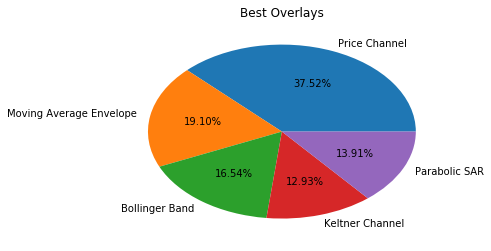

In [595]:
percentages = [float(len(priceChannel))/len(bestOver['Best Overlay']), float(len(movingEnvelope))/len(bestOver['Best Overlay']),
              float(len(bollingerBand))/len(bestOver['Best Overlay']), float(len(keltnerChannel))/len(bestOver['Best Overlay']),
              float(len(parabolicSAR))/len(bestOver['Best Overlay'])]
labels = ["Price Channel", "Moving Average Envelope", "Bollinger Band", "Keltner Channel", "Parabolic SAR"]
plt.pie(percentages, labels=labels, autopct='%1.2f%%')
plt.title('Best Overlays')
plt.show()

The cell creates a dataframe that shows how much money each overlay made for each stock.

In [584]:
stockDF = pd.DataFrame()
stockDF['Stock'] = newStocks[0]
stockDF['Bollinger Band'] = endMoneyBB[1]
stockDF['Keltner Channel'] = endMoneyKC[1]
stockDF['Moving Average Envelope'] = endMoneyME[1]
stockDF['Price Channel'] = endMoneyPC[1]
stockDF['Parabolic SAR'] = endMoneyPSAR[1]
print stockDF.head()
#stockDF.to_csv("stocksDF.csv")

               Stock  Bollinger Band  Keltner Channel  \
0  ./stocks/AABA.csv    15043.738459     16600.638469   
1   ./stocks/AAL.csv    11108.857474     11018.047499   
2  ./stocks/AAME.csv     7790.656829      7687.106829   
3  ./stocks/AAOI.csv    15321.024519     15095.954540   
4  ./stocks/AAON.csv    10936.585902     10662.636008   

   Moving Average Envelope  Price Channel  Parabolic SAR  
0             12736.918128   10341.580403   17439.426901  
1             10865.407600   12330.150222    9973.041299  
2              7103.146829    8425.800000    6835.231759  
3             13678.224585   11516.110904   12896.527605  
4             11136.885881   11890.549614   10339.098558  


The cell creates a dataframe that stores whether the overlay is the best for each stock by 0 or 1. If the overlay is the best for that stock, it is stored as a 1. If it is not the best, it is stored as a 0.

In [583]:
stockNameArray = []
stockDF2 = pd.DataFrame()
BB = []
KC = []
ME = []
PC = []
PSAR = []
for i in range(len(stockDF['Stock'])):
    stockString = stockDF['Stock'][i].split('/')
    stockName = stockString[2].split('.')[0]
    stockNameArray.append(stockName)
    if(bestOver['Best Overlay'][i] == 'Bollinger Band'):
        BB.append(1)
        KC.append(0)
        ME.append(0)
        PC.append(0)
        PSAR.append(0)
    elif(bestOver['Best Overlay'][i] == 'Keltner Channel'):
        BB.append(0)
        KC.append(1)
        ME.append(0)
        PC.append(0)
        PSAR.append(0)
    elif(bestOver['Best Overlay'][i] == 'Moving Envelope'):
        BB.append(0)
        KC.append(0)
        ME.append(1)
        PC.append(0)
        PSAR.append(0)
    elif(bestOver['Best Overlay'][i] == 'Parabolic SAR'):
        BB.append(0)
        KC.append(0)
        ME.append(0)
        PC.append(0)
        PSAR.append(1)
    elif(bestOver['Best Overlay'][i] == 'Price Channel'):
        BB.append(0)
        KC.append(0)
        ME.append(0)
        PC.append(1)
        PSAR.append(0)
    else:
        print "error row: " + i
stockDF2['Stock'] = stockNameArray
stockDF2['Bollinger Band'] = BB
stockDF2['Keltner Channel'] = KC
stockDF2['Moving Envelope'] = ME
stockDF2['Parabolic SAR'] = PSAR
stockDF2['Price Channel'] = PC
print stockDF2.head()
#stockDF2.to_csv("stock01.csv")

  Stock  Bollinger Band  Keltner Channel  Moving Envelope  Parabolic SAR  \
0  AABA               0                0                0              1   
1   AAL               0                0                0              0   
2  AAME               0                0                0              0   
3  AAOI               1                0                0              0   
4  AAON               0                0                0              0   

   Price Channel  
0              0  
1              1  
2              1  
3              0  
4              1  
